Fitting amplitudes using scipy wrapper library [lmfit](https://lmfit.github.io/lmfit-py/)

In [67]:
from lmfit import Parameters

paramsR = Parameters()
paramsL = Parameters()
paramsC = Parameters()

paramsR.add('R_r',996.7, min=950, max=1500)
paramsR.add('R',2000,min=1.5e03, max=3e03)
paramsR.add('L',4.741e-02, min=3.0e-02, max=5.5e-02)
paramsR.add('C',1.46e-09, min=1e-09, max=2e-09)
paramsR.add('V_0',2.4,min=0.0,max=3.0)

paramsL.add('R',min=1.5e03, max=3e03)
paramsL.add('L',4.741e-02, min=3.0e-02, max=5.5e-02)
paramsL.add('C',1.46e-09, min=1e-09, max=2e-09)
paramsL.add('V_0',1.5,min=0.0,max=3.0)

paramsC.add('R',min=1.5e03, max=3e03)
paramsC.add('L',4.741e-02, min=3.0e-02, max=5.5e-02)
paramsC.add('C',1.46e-09, min=1e-09, max=2e-09)
paramsC.add('V_0',1.5,min=0.0,max=3.0)


We estimate the uncertainty on the amplitudes measurements as the standard deviation of a sample population obtained with a squared wave at f = 19kHz(#TODO rimisura a freequenza piu bassa)

In [68]:
import numpy as np

folder = 'data/actual data/Voltage-time/'
file_name = 'freq19kHz.csv'
data_file = folder + file_name
swAmpGen  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (1), unpack = True)
swAmpPositive = []
for x in range(len(swAmpGen)):
    if (swAmpGen[x] > 0.0):
        swAmpPositive.append(swAmpGen[x])
swAmpNegative = []
for x in range(len(swAmpGen)):
    if (swAmpGen[x] < 0.0):
        swAmpNegative.append(swAmpGen[x])

In [69]:
from statistics import stdev
errorePos = stdev(swAmpPositive)
erroreNeg = stdev(swAmpNegative)
print("Deviazione standard sulle ampiezze positive della tensione del generatore: ",'{:.4f}'.format(errorePos))
print("Deviazione standard sulle ampiezze negative della tensione del generatore: ",'{:.4f}'.format(erroreNeg))

Deviazione standard sulle ampiezze positive della tensione del generatore:  0.0506
Deviazione standard sulle ampiezze negative della tensione del generatore:  0.0477


Now importing the experimental data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

file_folder = 'data/actual data/Frequency response/'
file_name = 'amplitudes1.csv'
data_file = file_folder + file_name
x,ampGen,ampR,ampL,ampC  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0,1,2,3,4), unpack = True)


We now assume the previously calculated value to be the error on all the measurements

In [71]:
errors = []
for i in range(len(ampGen)):
   errors.append(errorePos)

weights = np.reciprocal(errors)

Now defining the models our data will be fitted to:

We now define the function we are going to fit the data with: $$ V_R = \frac{R_rV_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_L = \frac{\omega L V_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_C = \frac{\frac{V_0}{\omega C}}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$

 $\omega = 2 \pi f$ with $f$ being the sinusoidal generator frequency. We've chosen to estimate the uncertainty associated to the amplitude measures with the sample standard deviation $\sigma$ since how the DAQ program outputs the amplitude values is not known.


In [72]:
def R_amp_model(x, R_r , R, L, C, V_0):
    num = R_r * V_0
    den = np.sqrt( R**2 + (2*np.pi*x* L - 1/(2*np.pi*x* C))**2)
    return num / den
def L_amp_model(x, R, L, C, V_0):
    num = 2*np.pi*x *L * V_0
    den = np.sqrt( R**2 + (2*np.pi*x *L - 1/(2*np.pi*x *C))**2)
    return num / den
def C_amp_model(x, R, L, C, V_0):
    num = V_0 / (2*np.pi*x *C)
    den = np.sqrt( R**2 + (2*np.pi*x *L - 1/(2*np.pi*x *C))**2)
    return num / den

Rmodel = Model(R_amp_model)
Lmodel = Model(L_amp_model)
Cmodel = Model(C_amp_model)


Now performing the fits:

In [73]:
# by default model='leastsq'
resultR = Rmodel.fit(ampR,x=x,params=paramsR,weights=weights)
resultL = Lmodel.fit(ampL,x=x,params=paramsL,weights=weights)
resultC = Cmodel.fit(ampC,x=x,params=paramsC,weights=weights)

...And printing out the fit results

R

[[Model]]
    Model(R_amp_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 986
    # variables        = 5
    chi-square         = 23.5589709
    reduced chi-square = 0.02401526
    Akaike info crit   = -3671.87158
    Bayesian info crit = -3647.40330
[[Variables]]
    R_r:  1040.97741 +/- 13887169.8 (1334051.03%) (init = 996.7)
    R:    2113.81408 +/- 2519426.96 (119188.67%) (init = 2000)
    L:    0.04900916 +/- 58.4133700 (119188.67%) (init = 0.04741)
    C:    1.4586e-09 +/- 1.7385e-06 (119188.65%) (init = 1.46e-09)
    V_0:  2.49491404 +/- 33268.4461 (1333450.59%) (init = 2.4)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, C)     = -1.000
    C(R, L)     = 1.000
    C(R, C)     = -1.000
    C(R_r, V_0) = -0.996
L

[[Model]]
    Model(L_amp_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 986
    # variables        = 4
    chi-square    

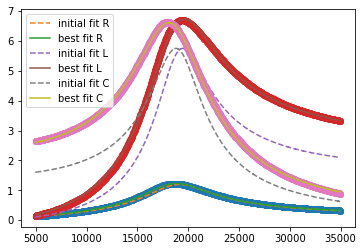

In [74]:
print('R\n')
print(resultR.fit_report())
print('L\n')
print(resultL.fit_report())
print('C\n')
print(resultC.fit_report())
plt.plot(x, ampR, 'o')
plt.plot(x, resultR.init_fit, '--', label='initial fit R')
plt.plot(x, resultR.best_fit, '-', label='best fit R')
plt.plot(x, ampL, 'o')
plt.plot(x, resultL.init_fit, '--', label='initial fit L')
plt.plot(x, resultL.best_fit, '-', label='best fit L')
plt.plot(x, ampC, 'o')
plt.plot(x, resultC.init_fit, '--', label='initial fit C')
plt.plot(x, resultC.best_fit, '-', label='best fit C')
plt.legend()

plt.savefig('figs/amplitudes.pdf')
plt.show()

Alternative plotting

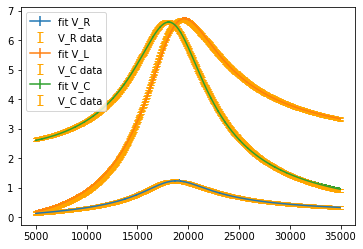

In [75]:
errore = errorePos
standard_frequencies = np.linspace(5000, 35000, 100)

plt.errorbar(x, resultR.best_fit,xerr=None,yerr=errore, label='fit V_R')
plt.errorbar(x, ampR,
             xerr=None, yerr=errore,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_R data")
plt.errorbar(x, resultL.best_fit,xerr=None,yerr=errore, label='fit V_L')
plt.errorbar(x, ampL,
             xerr=None, yerr=errore,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_C data")
plt.errorbar(x, resultC.best_fit,xerr=None,yerr=errore, label='fit V_C')
plt.errorbar(x, ampC,
             xerr=None, yerr=errore,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_C data")
plt.legend()

plt.savefig('figs/prova.pdf')